### Project description:
- The project aim is to apply the transfer learning method in a Deep Learning network using Python Language.
- The project used as a base is <a href="https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb">here</a>.

- The database used is a subset of the Birds 525 Species database obtained <a href="https://www.kaggle.com/datasets/gpiosenka/100-bird-species">here</a>. 
- 
Specifically, I used 7 classes of birds, each one with 100 images.

OBS: I tried to use the Colab environment, but it disconnected when I tried to train the network, so because of that, I used Jupyter notebook. 

In [27]:
%matplotlib inline

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

In [4]:
# get all the classes in the specifyed directory
root = 'birds_DB_2'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print(f'Type: {type(categories)}')
print(f'Number of categories: {len(categories)}')
for elem in categories:
    print(elem)

Type: <class 'list'>
Number of categories: 7
birds_DB_2\ABBOTTS BABBLER
birds_DB_2\ABBOTTS BOOBY
birds_DB_2\ABYSSINIAN GROUND HORNBILL
birds_DB_2\AFRICAN CROWNED CRANE
birds_DB_2\AFRICAN EMERALD CUCKOO
birds_DB_2\AFRICAN FIREFINCH
birds_DB_2\AFRICAN OYSTER CATCHER


In [5]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
# load all the images from the root folder
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [7]:
# reandomize the data order
random.shuffle(data)

In [8]:
# create training / validation / test split (70%, 15%, 15%)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

print(f"train data len: {len(train)}")
print(f"val data len: {len(val)}")
print(f"test data len: {len(test)}")

train data len: 489
val data len: 106
test data len: 105


In [11]:
# separate data for labels
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
# print(y_test)

**Pre-process data making sure it is float32 and normalized between 0 and 1**

In [12]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(105, 7)


In [13]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 700 images from 7 categories
train / validation / test split: 489, 106, 105
training data shape:  (489, 224, 224, 3)
training labels shape:  (489, 7)


In [14]:
# analysing the shape and the variables types
print(f"x_train shape: {x_train.shape}")
print(f"x_train type: {type(x_train)}")

print(f"x_val shape: {x_val.shape}")
print(f"x_val type: {type(x_val)}")

print(f"x_test shape: {x_test.shape}")
print(f"x_test type: {type(x_test)}")

x_train shape: (489, 224, 224, 3)
x_train type: <class 'numpy.ndarray'>
x_val shape: (106, 224, 224, 3)
x_val type: <class 'numpy.ndarray'>
x_test shape: (105, 224, 224, 3)
x_test type: <class 'numpy.ndarray'>


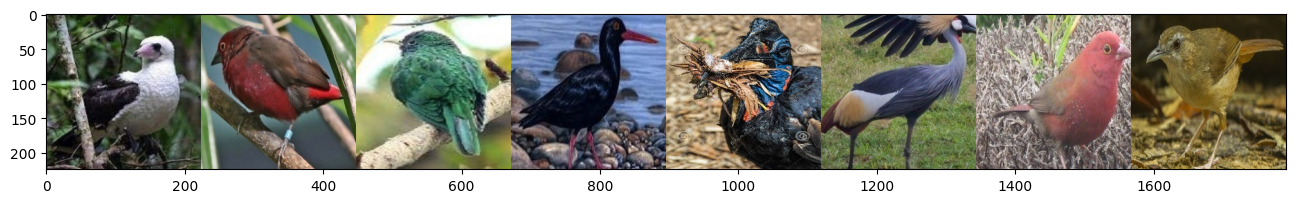

In [15]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image);

**First - Training a neural net from scratch**

In [16]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                  

In [18]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))

Epoch 1/15
4/4 [==============================] - 10s 2s/step - loss: 1.1251 - accuracy: 0.5726 - val_loss: 1.0577 - val_accuracy: 0.7358
Epoch 2/15
4/4 [==============================] - 9s 2s/step - loss: 0.9226 - accuracy: 0.6912 - val_loss: 0.9238 - val_accuracy: 0.7170
Epoch 3/15
4/4 [==============================] - 9s 2s/step - loss: 0.8609 - accuracy: 0.7117 - val_loss: 0.9791 - val_accuracy: 0.6698
Epoch 4/15
4/4 [==============================] - 9s 2s/step - loss: 0.7883 - accuracy: 0.7403 - val_loss: 0.7748 - val_accuracy: 0.7736
Epoch 5/15
4/4 [==============================] - 9s 2s/step - loss: 0.6636 - accuracy: 0.7894 - val_loss: 0.8061 - val_accuracy: 0.7453
Epoch 6/15
4/4 [==============================] - 9s 2s/step - loss: 0.6585 - accuracy: 0.7710 - val_loss: 0.7215 - val_accuracy: 0.7830
Epoch 7/15
4/4 [==============================] - 9s 2s/step - loss: 0.5412 - accuracy: 0.8221 - val_loss: 0.7354 - val_accuracy: 0.7736
Epoch 8/15
4/4 [========================

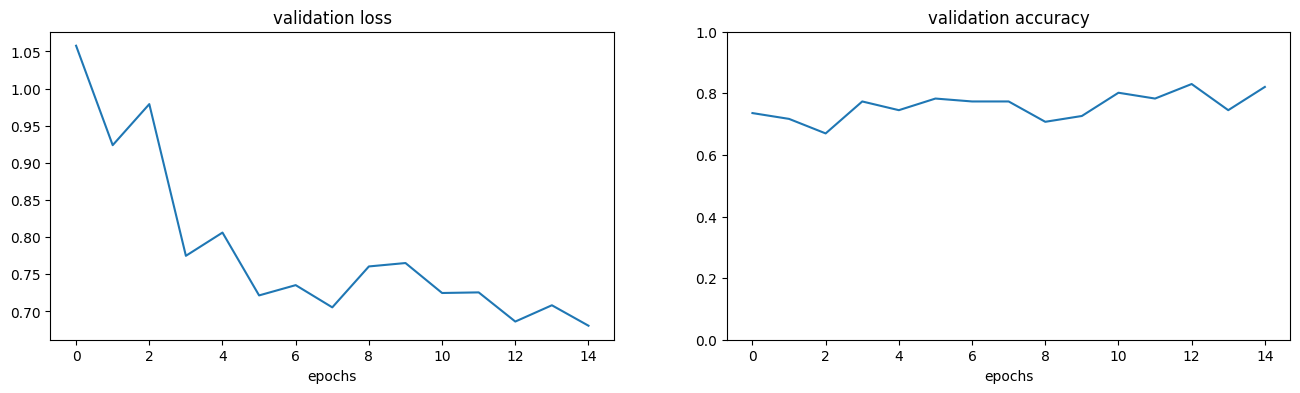

In [19]:
# plot of validation loss and validation accuracy over time
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [20]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.1562349796295166
Test accuracy: 0.6095238327980042


**Transfer learning by starting with existing network**

In [21]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [23]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
# fit the model
history2 = model_new.fit(x_train, y_train,
                        batch_size = 128,
                        epochs = 15,
                        validation_data = (x_val, y_val))

Epoch 1/15
4/4 [==============================] - 58s 15s/step - loss: 0.5551 - accuracy: 0.8957 - val_loss: 0.5830 - val_accuracy: 0.8491
Epoch 2/15
4/4 [==============================] - 60s 15s/step - loss: 0.5372 - accuracy: 0.8855 - val_loss: 0.5596 - val_accuracy: 0.8679
Epoch 3/15
4/4 [==============================] - 60s 16s/step - loss: 0.5109 - accuracy: 0.9121 - val_loss: 0.5515 - val_accuracy: 0.8774
Epoch 4/15
4/4 [==============================] - 60s 16s/step - loss: 0.4993 - accuracy: 0.9141 - val_loss: 0.5441 - val_accuracy: 0.8679
Epoch 5/15
4/4 [==============================] - 60s 16s/step - loss: 0.4796 - accuracy: 0.9080 - val_loss: 0.5240 - val_accuracy: 0.9057
Epoch 6/15
4/4 [==============================] - 61s 16s/step - loss: 0.4722 - accuracy: 0.9141 - val_loss: 0.5105 - val_accuracy: 0.8774
Epoch 7/15
4/4 [==============================] - 60s 16s/step - loss: 0.4596 - accuracy: 0.9080 - val_loss: 0.5280 - val_accuracy: 0.8679
Epoch 8/15
4/4 [===========

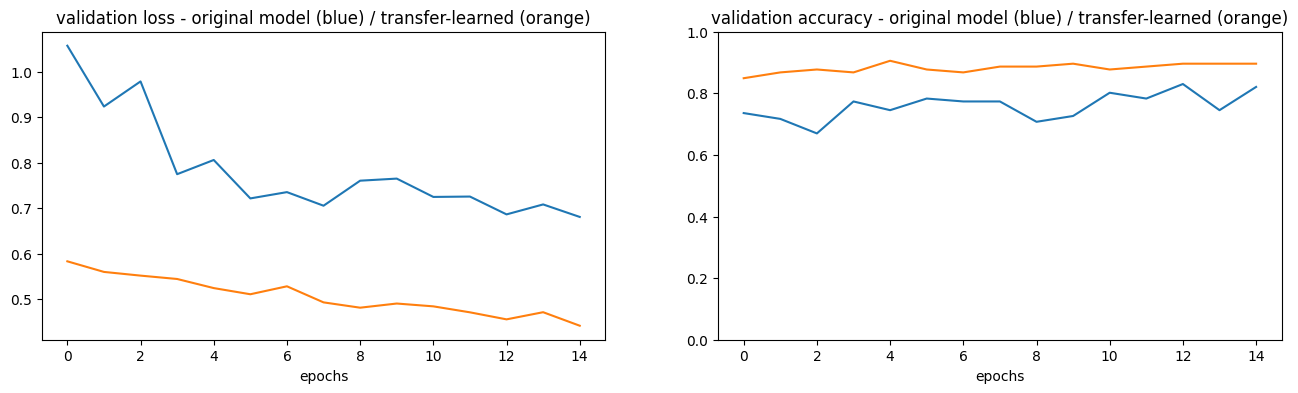

In [36]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss - original model (blue) / transfer-learned (orange)")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy - original model (blue) / transfer-learned (orange)")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [37]:
# evaluating the model
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5392287969589233
Test accuracy: 0.8666666746139526


- The test accuracy obtained not using transfer learning was 0.61, while the test loss was 1.16, aproximately.  - 
The test accuracy obtained using transfer learning was 0.87, while the test loss was 0.54, aproximately.
- 
So, for the task of classificating categories of birds, when we used transfer learning (VGG), the test accuracy improved an amount of 0.26, aproximately. 